In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:
class PMF(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, data, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()


    def model(self, train, mask):
     

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
            with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.Poisson(UA@VA.T), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=250, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.predictive_svi = predictive_svi
        #print(table)
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table

    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score = dist.Poisson(UA@VA.T).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    
   
       

In [4]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)
nan_mask = np.isnan(data) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )


(1127, 5237)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [5]:
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(500)
        score.append(test.predictive_score(data_all,  ~torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF)


(1127, 5237)
UA: (500, 1, 1127, 1)
VA: (500, 1, 5237, 1)
target: (500, 1127, 5237)
torch.Size([1127, 1])
UA: (500, 1, 1127, 5)
VA: (500, 1, 5237, 5)
target: (500, 1127, 5237)
torch.Size([1127, 5])
UA: (500, 1, 1127, 10)
VA: (500, 1, 5237, 10)
target: (500, 1127, 5237)
torch.Size([1127, 10])
UA: (500, 1, 1127, 20)
VA: (500, 1, 5237, 20)
target: (500, 1127, 5237)
torch.Size([1127, 20])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 75)
VA: (500, 1, 5237, 75)
target: (500, 1127, 5237)
torch.Size([1127, 75])
UA: (500, 1, 1127, 100)
VA: (500, 1, 5237, 100)
target: (500, 1127, 5237)
torch.Size([1127, 100])
UA: (500, 1, 1127, 200)
VA: (500, 1, 5237, 200)
target: (500, 1127, 5237)
torch.Size([1127, 200])
UA: (500, 1, 1127, 250)
VA: (500, 1, 5237, 250)
target: (500, 1127, 5237)
torch.Size([1127, 250])


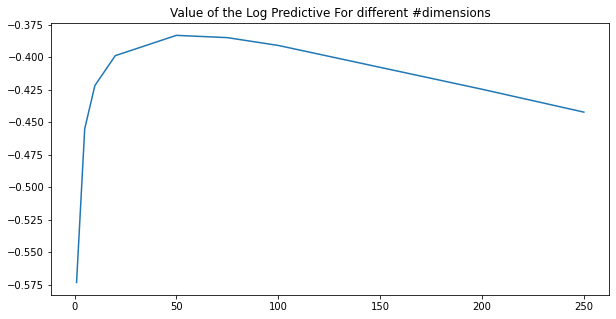

In [10]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
plt.savefig("predictive_score_simple.png")
plt.show()
pyro.clear_param_store()

In [11]:

test = PMF(data, train=data, dim=50)
l = test.train_SVI(data, ~torch.from_numpy(nan_mask))


Elbo loss: 1154458218.0
Elbo loss: 187166798.19140625
Elbo loss: 64558026.240234375
Elbo loss: 38171677.46191406
Elbo loss: 33257379.75
Elbo loss: 31130139.90625
Elbo loss: 29894891.3359375
Elbo loss: 28238318.9453125
Elbo loss: 25987876.65625
Elbo loss: 23630812.50390625
Elbo loss: 22325087.8203125
Elbo loss: 21060175.3125
Elbo loss: 20078680.4375
Elbo loss: 19810330.3359375
Elbo loss: 19051402.1875
Elbo loss: 18562975.4296875
Elbo loss: 18809184.7421875
Elbo loss: 18452862.0234375
Elbo loss: 18151757.640625
Elbo loss: 18007491.515625
Elbo loss: 17961212.625
Elbo loss: 17562170.2578125
Elbo loss: 17172043.828125
Elbo loss: 17404447.546875
Elbo loss: 17680716.8515625


In [7]:
test.sample_predict(10)

UA: (10, 1, 1127, 100)
VA: (10, 1, 5237, 100)
target: (10, 1127, 5237)


In [7]:
test.rmse(data)
print(test.get_predictions())
print(data)

PMF MAP training RMSE: 0.36516
AUC: 0.83883
[[1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 1  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  1  8  0]
 ...
 [ 8  0  0 ... 10 12  0]
 [ 1  0  0 ...  4 25  0]
 [ 0  0  0 ...  0  0  0]]


In [4]:
class PMF_intercepts(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = train.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()

        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
       
        self.bias = self.data.mean()


    def model(self, train):

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            drug_intercept = pyro.sample("drug_int", dist.HalfNormal(0.5))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            sideeffect_intercept = pyro.sample("sf_int", dist.HalfNormal(0.5))
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)
       #with u2_plate:
           
            
        with sideeffect_plate, u2_plate: 
            #Y = pyro.sample("target", dist.Poisson(UA@VA.T  +sideeffect_intercept.T), obs=train ) z[:, np.newaxis] + x
            Y = pyro.sample("target", dist.Poisson(UA@VA.T  + (drug_intercept[:, np.newaxis] + sideeffect_intercept.T)), obs=train ) 
            return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
        
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items
        se_t = pyro.param("sef_int", 0.25*torch.ones(self.m), constraint=constraints.positive)
        drug_t = pyro.param("drug_int_p", 0.25*torch.ones(self.n), constraint=constraints.positive)
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

       # with u2_plate:
          #  drug_intercept = pyro.sample("drug_int", dist.HalfNormal(drug_t).to_event(1))

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
            UA_int = pyro.sample("UAint", dist.HalfNormal(drug_t))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
            sideeffect_intercept =  pyro.sample("sf_int", dist.HalfNormal(se_t))
    
    def train_SVI(self,train, nsteps=250, lr = 0.05, lrd = 1):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float())
            losses.append(elbo)
            if step % 10 == 0:
                print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)( None)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return self.predictions

    
   
test = PMF_intercepts(data, 100)       

In [6]:

test.train_SVI(data)


Elbo loss: 16507036.471118927
Elbo loss: 16882178.70968628
Elbo loss: 16316151.067085266
Elbo loss: 16288115.850841522
Elbo loss: 16257655.711566925
Elbo loss: 16270344.331485748
Elbo loss: 16342345.294166565
Elbo loss: 15919929.547546387
Elbo loss: 16114426.330440521
Elbo loss: 15449073.024482727
Elbo loss: 15926813.614624977
Elbo loss: 15586750.751041412
Elbo loss: 15827920.701267242
Elbo loss: 15714445.02986908
Elbo loss: 15497542.100240707
Elbo loss: 15426100.48765564
Elbo loss: 15437820.758758545
Elbo loss: 15585684.149702072
Elbo loss: 15870064.738471985
Elbo loss: 15594255.186466217
Elbo loss: 15578450.936626434
Elbo loss: 15589500.542766571
Elbo loss: 15133441.503730774
Elbo loss: 15588512.186912537
Elbo loss: 15487589.70847702


[16507036.471118927,
 16496506.882324219,
 16725043.243679047,
 16757541.569824219,
 16918150.519577026,
 16833062.85477066,
 16704408.156257153,
 16910661.563728333,
 16673162.07164669,
 17017526.848858833,
 16882178.70968628,
 16528738.827140808,
 16472368.863552094,
 16625404.072410583,
 16564866.971096039,
 16570515.512786865,
 16734607.416477203,
 16479054.055652618,
 16483060.28685379,
 16532277.746879578,
 16316151.067085266,
 16505781.601371765,
 16345559.011214256,
 16548068.182533264,
 16689426.65473175,
 16392662.219470024,
 16446702.082932472,
 16294120.535728455,
 16434014.2137146,
 16128583.033908844,
 16288115.850841522,
 16416165.300584793,
 16276428.832092285,
 16078770.043344498,
 16182646.042268753,
 16126891.797328949,
 16419918.408088684,
 16246004.408210754,
 16403620.063171387,
 16164927.168022156,
 16257655.711566925,
 16272669.908325195,
 15973345.710792542,
 16108965.42982483,
 15875432.667793274,
 16125924.253845215,
 16135030.776966095,
 16107974.334237576,


In [7]:
test.sample_predict(1000)



UA: (1000, 1, 1127, 100)
drug_int: (1000, 1, 1127)
sf_int: (1000, 1, 5237)
VA: (1000, 1, 5237, 100)
target: (1000, 1127, 5237)


In [8]:
test.rmse(data)
print(test.get_predictions())
print(data)


PMF MAP training RMSE: 0.36189
AUC: 0.84249
[[1. 1. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 1  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  1  8  0]
 ...
 [ 8  0  0 ... 10 12  0]
 [ 1  0  0 ...  4 25  0]
 [ 0  0  0 ...  0  0  0]]


In [7]:
#Testing!!!

n,m = data.shape
dim=10
alpha_u = 4
alpha_v=5
beta_u=1
beta_v=1
def model():

        drug_plate = pyro.plate("drug_latents", n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", m, dim= -1) #independent items
   

        with drug_plate:
            
            UA = pyro.sample("UA2", dist.Gamma(alpha_u, beta_u).expand([dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            sideeffect_intercept = pyro.sample("sf_int", dist.HalfNormal(0.5))

            VA = pyro.sample("VA2", dist.Gamma(alpha_v, beta_v).expand([dim]).to_event(1))
        
        u2_plate = pyro.plate("u2_plate", n, dim=-2)
        with u2_plate:
            drug_intercept = pyro.sample("drug_int", dist.HalfNormal(0.5))

        with sideeffect_plate, u2_plate: 
            Y = pyro.sample("target", dist.Poisson( UA@VA.T+sideeffect_intercept.T ) ) 
            return Y

def guide9():

        d_alpha = pyro.param('d_alpha', 5*torch.ones(n,dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.05*torch.ones(n,dim), constraint=constraints.positive)
        # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
        # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
            #                  constraint=constraints.positive)
        s_alpha = pyro.param('s_alpha', 5*torch.ones(m,dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.05*torch.ones(m,dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents",n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents",m, dim= -1) #independent items
        se_t = pyro.param("sef_int", 0.25*torch.ones(m), constraint=constraints.positive)
        drug_t = pyro.param("drug_int_p", 0.25*torch.ones(n), constraint=constraints.positive)
        u2_plate = pyro.plate("u2_plate", n, dim=-2)
        with u2_plate:
            drug_intercept = pyro.sample("drug_int", dist.HalfNormal(drug_t).to_event(1))

        
        with drug_plate: 
            UA = pyro.sample("UA2", dist.Gamma(d_alpha, d_beta).to_event(1))
            # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
     
        
        with sideeffect_plate: 
            VA = pyro.sample("VA2", dist.Gamma(s_alpha, s_beta).to_event(1))
            sideeffect_intercept =  pyro.sample("sf_int", dist.HalfNormal(se_t))

    
def model6():
    d = 50
    N = 100
    
    # Vector of variances for each of the d variables
    theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(d)))
    # Lower cholesky factor of a correlation matrix
    concentration = torch.ones(
        (), 
    )  # Implies a uniform distribution over correlation matrices
    L_omega = pyro.sample("L_omega", dist.LKJCholesky(d, concentration))
    # Lower cholesky factor of the covariance matrix
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    # For inference with SVI, one might prefer to use torch.bmm(theta.sqrt().diag_embed(), L_omega)

    # Vector of expectations
    mu = torch.zeros(d)

    with pyro.plate("observations", N):
        obs = pyro.sample("obs", dist.MultivariateNormal(mu, scale_tril=L_Omega))
    return obs


In [8]:
trace=poutine.trace(model6).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

trace=poutine.trace(guide9).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

    Trace Shapes:            
     Param Sites:            
    Sample Sites:            
       theta dist  50 |      
            value  50 |      
         log_prob  50 |      
     L_omega dist     | 50 50
            value     | 50 50
         log_prob     |      
observations dist     |      
            value 100 |      
         log_prob     |      
         obs dist 100 | 50   
            value 100 | 50   
         log_prob 100 |      
          Trace Shapes:                    
           Param Sites:                    
                d_alpha      1127   10     
                 d_beta      1127   10     
                s_alpha      5237   10     
                 s_beta      5237   10     
                sef_int           5237     
             drug_int_p           1127     
          Sample Sites:                    
      drug_latents dist              |     
                  value      1127    |     
               log_prob              |     
sideeffect_latents dis

torch.Size([1127, 5237])
torch.Size([1127, 5237])
